In [3]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import math, sys, os
from numpy.random import randn
from sklearn.datasets import make_blobs

# setup pyspark for IPython_notebooks
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/

Using Python version 2.7.10 (default, Jul 13 2015 12:05:58)
SparkContext available as sc, HiveContext available as sqlContext.


In [60]:
data_home = os.environ.get('DATA_HOME', None)
sys.path.insert(0, data_home)

# data
from gen_data import make_blobs_rdd

# utilitiy functions for this notebook
from lsh_util import *

# make some data
N = 1000
d = 2
k = 5
sigma = 1
bound = 10*sigma

data_RDD = make_blobs_rdd(N, d, k, sigma, bound, sc)
data_RDD.take(2)

[(2, array([-1.56500925, -1.1465788 ])),
 (4, array([ 1.23101689,  0.7231538 ]))]

# Random projection LSH

In [61]:
def config_random_projection(d, n_hyperplanes = 5, scale = 2.0, seed = None):    
    # random projection vectors
    Z = (np.random.rand(d, n_hyperplanes) - 0.5) * scale
    def projection_func(tup):
        y, x = tup # expect key (int, 1xD vector)
        projs = x.T.dot(Z) # random projections
        bucket = to_bucket(projs)
        return (bucket, y)
    
    return (Z,projection_func)

In [62]:
Z, hash_func = config_random_projection(d)

gini_impurities = data_RDD.map(hash_func).map(to_dict).reduceByKey(reduce_count_clusters).map(gini_impurity).collect()
for b, g, c in sorted(gini_impurities):
    print "bucket: %s , in bucket: %d , gini_impurity: %f" % (b, c, g)

bucket: 6 , in bucket: 6 , gini_impurity: 0.000000
bucket: 10 , in bucket: 355 , gini_impurity: 0.508407
bucket: 11 , in bucket: 46 , gini_impurity: 0.000000
bucket: 14 , in bucket: 188 , gini_impurity: 0.010582
bucket: 17 , in bucket: 199 , gini_impurity: 0.019898
bucket: 20 , in bucket: 167 , gini_impurity: 0.000000
bucket: 21 , in bucket: 36 , gini_impurity: 0.152778
bucket: 25 , in bucket: 2 , gini_impurity: 0.000000
bucket: 27 , in bucket: 1 , gini_impurity: 0.000000


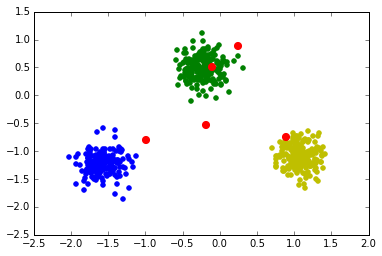

In [63]:
c0 = np.stack(data_RDD.filter(lambda t: t[0] == 0).map(lambda t: t[1]).collect())
c1 = np.stack(data_RDD.filter(lambda t: t[0] == 1).map(lambda t: t[1]).collect())
c2 = np.stack(data_RDD.filter(lambda t: t[0] == 2).map(lambda t: t[1]).collect())

plt.scatter(c0[:,0],c0[:,1],color='g')
plt.scatter(c1[:,0],c1[:,1],color='y')
plt.scatter(c2[:,0],c2[:,1],color='b')
plt.scatter(Z.T[:,0],Z.T[:,1],color='r',s=50)

In [64]:
# impurity as we scale up the number of hyperplanes used for projections

for n_Z in range(10,200,10):
    Z, hash_func = config_random_projection(d, n_Z)
    gini_impurities = data_RDD.map(hash_func).map(to_dict).reduceByKey(reduce_count_clusters).map(gini_impurity).collect()
    g_i = weighted_gini(gini_impurities)
    print "%d projections, gini_impurity: %f" % (n_Z, g_i)
    

10 projections, gini_impurity: 0.165665
20 projections, gini_impurity: 0.157024
30 projections, gini_impurity: 0.147843
40 projections, gini_impurity: 0.149566
50 projections, gini_impurity: 0.149959
60 projections, gini_impurity: 0.147694
70 projections, gini_impurity: 0.143743
80 projections, gini_impurity: 0.145333
90 projections, gini_impurity: 0.141270
100 projections, gini_impurity: 0.145438
110 projections, gini_impurity: 0.136271
120 projections, gini_impurity: 0.136784
130 projections, gini_impurity: 0.136788
140 projections, gini_impurity: 0.137037
150 projections, gini_impurity: 0.138656
160 projections, gini_impurity: 0.132953
170 projections, gini_impurity: 0.140970
180 projections, gini_impurity: 0.132052
190 projections, gini_impurity: 0.129358
